In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools

import sys
sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
import utils




Question: Can we use the correlation between two series to predict the value of one from the other with any meaningful lead?

In [4]:
#open and combine all data

base_key = 'BTCUSD'
other_keys =('ETHUSD', 'SOLUSD', 'DOTUSD', 'ADAUSD', 'ALGOUSD')
full_df = pd.read_csv(os.path.join('..', 'data', 'scraped_OHLC', base_key+'.csv'))
full_df['dtime'] = pd.to_datetime(full_df['dtime'], format='%Y-%m-%d %H:%M:%S')
full_df.set_index('dtime', inplace = True)
full_df.drop(columns=['time'], inplace=True)
full_df = full_df.add_prefix(base_key+'_')

for key in other_keys:
    price_data = pd.read_csv(os.path.join('..', 'data', 'scraped_OHLC', key+'.csv'))
    price_data['dtime'] = pd.to_datetime(price_data['dtime'], format='%Y-%m-%d %H:%M:%S')
    price_data.set_index('dtime', inplace = True)
    price_data.drop(columns=['time'], inplace=True)
    price_data = price_data.add_prefix(key+'_')
    full_df = pd.merge_asof(full_df, price_data, left_index=True, right_index=True, direction='nearest')

full_df.dropna(inplace=True, axis=0, how='all')

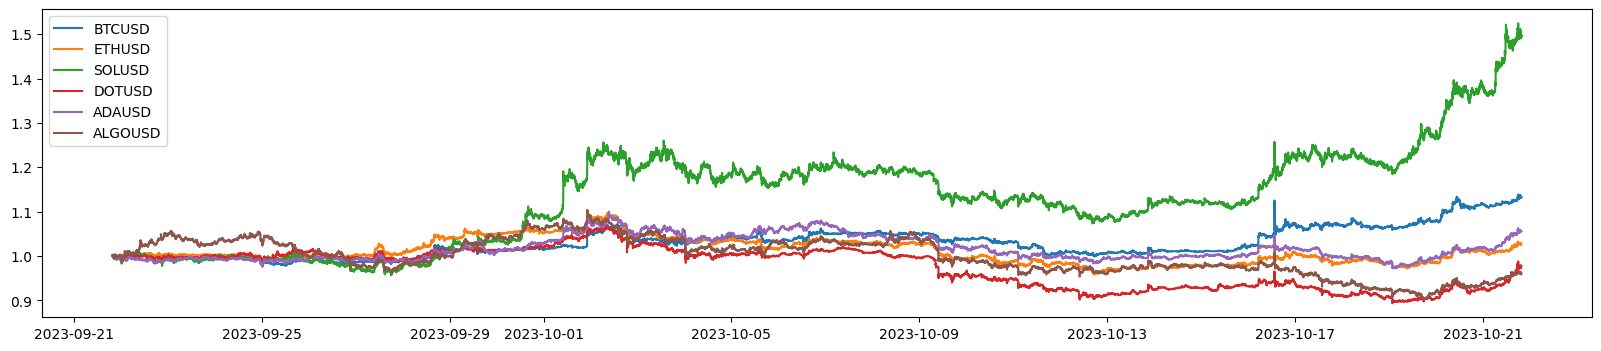

In [6]:
plt.rcParams['figure.figsize'] = [20, 4]

ohlc_key = 'close'
all_keys = [base_key] + list(other_keys)

for key in all_keys:
    plt.plot(utils.normalize_by_start(full_df[key + '_' + ohlc_key][-60*24*30:]))
plt.legend(all_keys)
plt.show()

In [7]:
key_combinations = list(itertools.combinations(all_keys, 2))
key_combinations

[('BTCUSD', 'ETHUSD'),
 ('BTCUSD', 'SOLUSD'),
 ('BTCUSD', 'DOTUSD'),
 ('BTCUSD', 'ADAUSD'),
 ('BTCUSD', 'ALGOUSD'),
 ('ETHUSD', 'SOLUSD'),
 ('ETHUSD', 'DOTUSD'),
 ('ETHUSD', 'ADAUSD'),
 ('ETHUSD', 'ALGOUSD'),
 ('SOLUSD', 'DOTUSD'),
 ('SOLUSD', 'ADAUSD'),
 ('SOLUSD', 'ALGOUSD'),
 ('DOTUSD', 'ADAUSD'),
 ('DOTUSD', 'ALGOUSD'),
 ('ADAUSD', 'ALGOUSD')]

In [8]:
keys_to_corr = ('BTCUSD', 'ETHUSD')
outer_segment_size = 60
corr_range = 5 #must be less than outer_segment_size / /2

results = {}
seg_start = 0
seg_end = outer_segment_size
results = {
    'max_cross_corr' : [],
    'idx_max_cross_corr' : [],
    }
while seg_end < len(full_df):
    seg_a = full_df[keys_to_corr[0] + '_' + ohlc_key][seg_start:seg_end].copy()
    seg_a -= np.mean(seg_a)
    seg_a /= np.std(seg_a)
    seg_b = full_df[keys_to_corr[1] + '_' + ohlc_key][seg_start + corr_range:seg_end - corr_range].copy()
    seg_b -= np.mean(seg_b)
    seg_b /= np.std(seg_b)
    cross_cor = np.correlate(seg_a, seg_b, 'valid')
    max_cross_corr = np.max(cross_cor)
    normalized = max_cross_corr / np.sqrt(np.sum(seg_a**2) * np.sum(seg_b**2))
    idx_max_cross_corr = np.argmax(cross_cor) - corr_range
    results['max_cross_corr'].append(max_cross_corr)
    results['idx_max_cross_corr'].append(idx_max_cross_corr)
    seg_start += outer_segment_size // 4
    seg_end += outer_segment_size // 4
        
    

C:\Users\avido\AppData\Local\Temp\ipykernel_38508\1466143404.py:21: RuntimeWarning: invalid value encountered in scalar divide
  normalized = max_cross_corr / np.sqrt(np.sum(seg_a**2) * np.sum(seg_b**2))
C:\Users\avido\AppData\Local\Temp\ipykernel_38508\1466143404.py:21: RuntimeWarning: invalid value encountered in scalar multiply
  normalized = max_cross_corr / np.sqrt(np.sum(seg_a**2) * np.sum(seg_b**2))


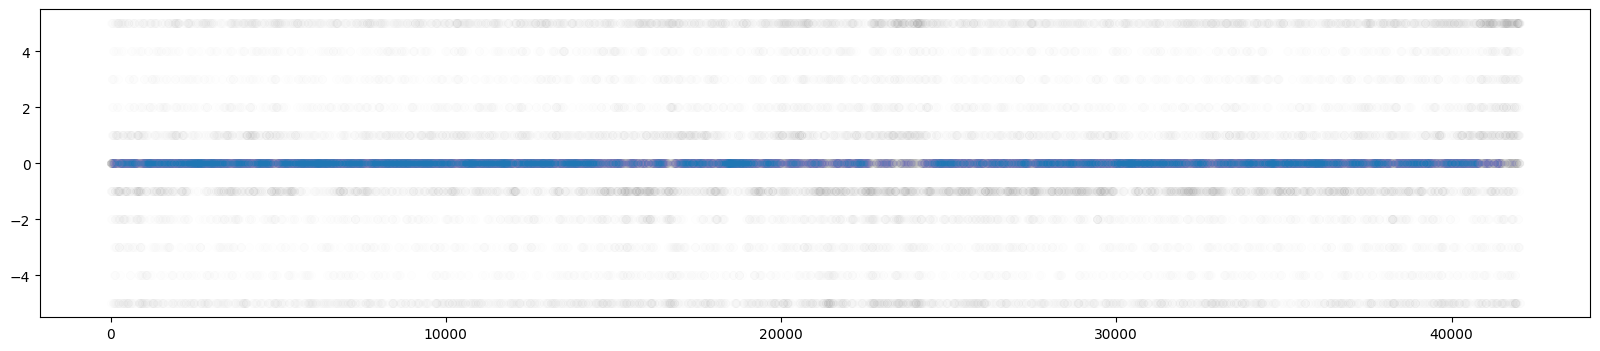

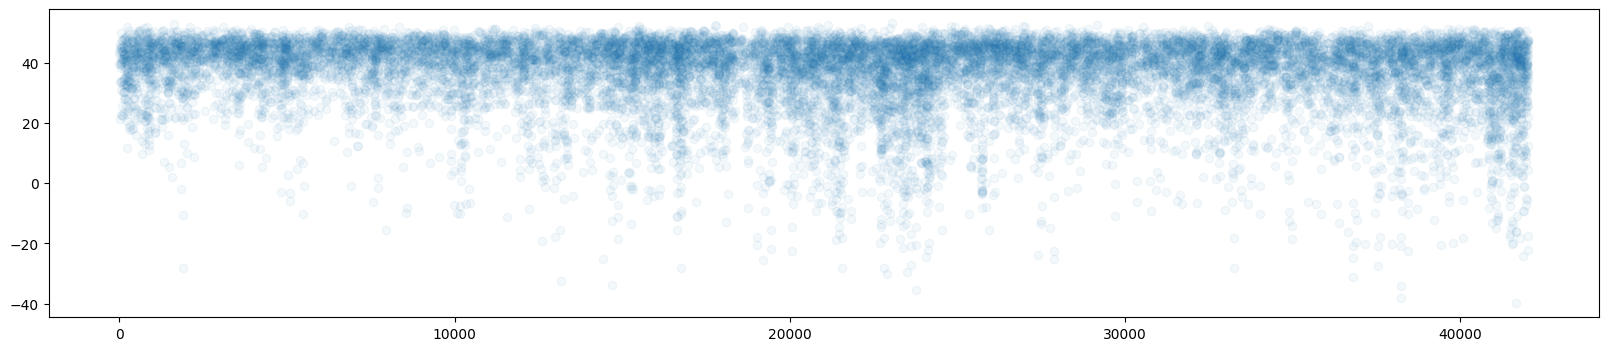

In [25]:
plt.rcParams['figure.figsize'] = [20, 4]

x = np.arange(len(results['max_cross_corr']))

plt.scatter(x, results['idx_max_cross_corr'], alpha=0.005)
plt.show()
plt.scatter(x[np.array(results['idx_max_cross_corr']) != 0], np.array(results['max_cross_corr'])[np.array(results['idx_max_cross_corr']) != 0], alpha=0.05)
plt.show()

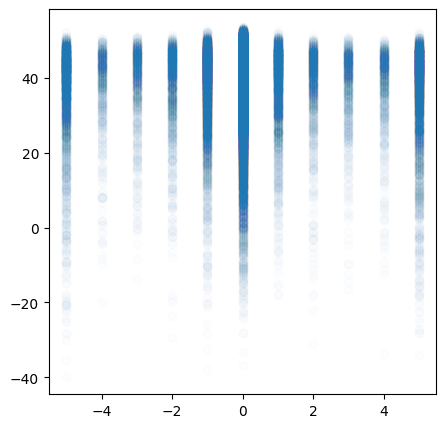

In [27]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(results['idx_max_cross_corr'], results['max_cross_corr'], alpha=0.01)
plt.show()


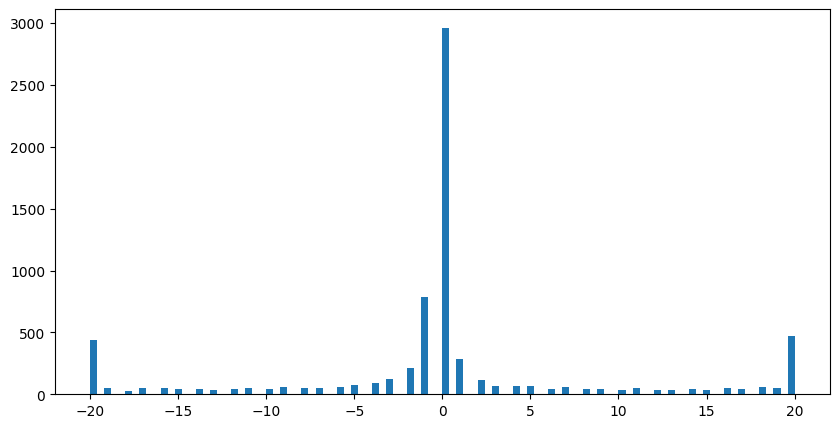

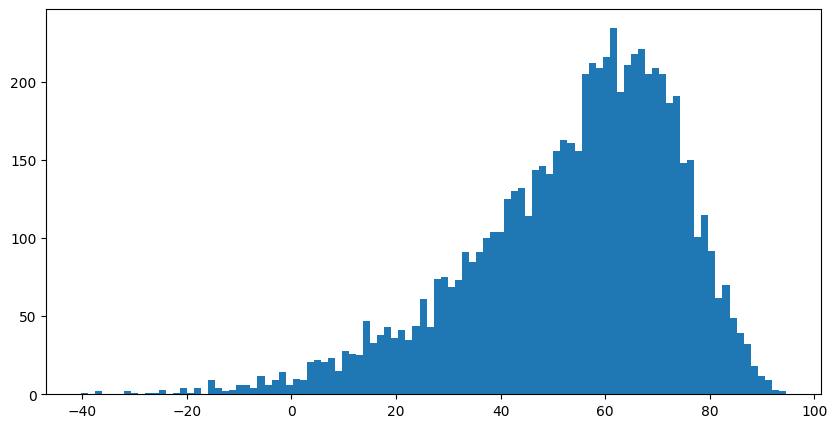

In [9]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.hist(results['idx_max_cross_corr'], bins = 100, range = (-corr_range , corr_range ))
plt.show()
plt.hist(results['max_cross_corr'], bins = 100)
plt.show()


looks like there is a significant proportion of time where there is a ~1 minute offset in max correlation. this would likely be hard to capitalize on though. I also still dont unsderstand why the boundaries are showing higher values.